In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_seed(SEED)

cpu


# Data preparation

In [3]:
train_dataset = FashionMNIST(
    "./data", train=True, download=True, transform=transforms.ToTensor()
)

test_dataset = FashionMNIST(
    "./data", train=False, download=True, transform=transforms.ToTensor()
)

100%|██████████| 26.4M/26.4M [00:10<00:00, 2.47MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 143kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:11<00:00, 388kB/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
train_ratio = 0.9
batch_size = 64
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


# Model training

## Baseline

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)

        x = self.layer2(x)
        x = nn.Sigmoid()(x)

        x = self.layer3(x)
        x = nn.Sigmoid()(x)

        x = self.layer4(x)
        x = nn.Sigmoid()(x)

        x = self.layer5(x)
        x = nn.Sigmoid()(x)

        x = self.layer6(x)
        x = nn.Sigmoid()(x)

        x = self.layer7(x)
        x = nn.Sigmoid()(x)

        x = self.output(x)
        return x

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(
    device
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

## Weight Increasing

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                # nn.init.normal_(module.weight, mean=0.0, std=10.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)

        x = self.layer2(x)
        x = nn.Sigmoid()(x)

        x = self.layer3(x)
        x = nn.Sigmoid()(x)

        x = self.layer4(x)
        x = nn.Sigmoid()(x)

        x = self.layer5(x)
        x = nn.Sigmoid()(x)

        x = self.layer6(x)
        x = nn.Sigmoid()(x)

        x = self.layer7(x)
        x = nn.Sigmoid()(x)

        x = self.output(x)
        return x

## Better Activation

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)

        x = self.layer2(x)
        x = nn.ReLU()(x)

        x = self.layer3(x)
        x = nn.ReLU()(x)

        x = self.layer4(x)
        x = nn.ReLU()(x)

        x = self.layer5(x)
        x = nn.ReLU()(x)

        x = self.layer6(x)
        x = nn.ReLU()(x)

        x = self.layer7(x)
        x = nn.ReLU()(x)

        x = self.output(x)
        return x

In [12]:
input_dims = 784
hidden_dims = 128
output_dims = 10

# Baseline network
model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(
    device
)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

## Normalize Inside Network

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.ReLU()(x)

        x = self.layer2(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.ReLU()(x)

        x = self.layer3(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.ReLU()(x)

        x = self.layer4(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.ReLU()(x)

        x = self.layer5(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.ReLU()(x)

        x = self.layer6(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.ReLU()(x)

        x = self.layer7(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.ReLU()(x)

        x = self.output(x)
        return x

## Customized Normalization Layer

In [16]:
class MyNormalization(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean) / std

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = MyNormalization()(x)
        x = nn.ReLU()(x)

        x = self.layer2(x)
        x = MyNormalization()(x)
        x = nn.ReLU()(x)

        x = self.layer3(x)
        x = MyNormalization()(x)
        x = nn.ReLU()(x)

        x = self.layer4(x)
        x = MyNormalization()(x)
        x = nn.ReLU()(x)

        x = self.layer5(x)
        x = MyNormalization()(x)
        x = nn.ReLU()(x)

        x = self.layer6(x)
        x = MyNormalization()(x)
        x = nn.ReLU()(x)

        x = self.layer7(x)
        x = MyNormalization()(x)
        x = nn.ReLU()(x)

        x = self.output(x)
        return x

## Skip Connection

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        skip = x

        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = skip + x

        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        skip = x

        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = skip + x

        x = self.output(x)
        return x

## Gradient Normalization

In [ ]:
# Custom Gradient Normalization Layer
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: pass input unchanged
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        # Normalize the gradient
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)  # Avoid division by zero
        return grad_input


# Wrapper Module for GradientNormalization
class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = GradientNormalizationLayer()(x)
        x = nn.ReLU()(x)

        x = self.layer2(x)
        x = GradientNormalizationLayer()(x)
        x = nn.ReLU()(x)

        x = self.layer3(x)
        x = GradientNormalizationLayer()(x)
        x = nn.ReLU()(x)

        x = self.layer4(x)
        x = GradientNormalizationLayer()(x)
        x = nn.ReLU()(x)

        x = self.layer5(x)
        x = GradientNormalizationLayer()(x)
        x = nn.ReLU()(x)

        x = self.layer6(x)
        x = GradientNormalizationLayer()(x)
        x = nn.ReLU()(x)

        x = self.layer7(x)
        x = GradientNormalizationLayer()(x)
        x = nn.ReLU()(x)

        x = self.output(x)
        return x

In [7]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)
    print(
        f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}"
    )

EPOCH 1/100, Train_Loss: 2.3042, Train_Acc: 0.0996, Validation Loss: 2.3062, Val_Acc: 0.0895
EPOCH 2/100, Train_Loss: 2.3038, Train_Acc: 0.0983, Validation Loss: 2.3041, Val_Acc: 0.0895
EPOCH 3/100, Train_Loss: 2.3039, Train_Acc: 0.0962, Validation Loss: 2.3043, Val_Acc: 0.1022
EPOCH 4/100, Train_Loss: 2.3039, Train_Acc: 0.1007, Validation Loss: 2.3036, Val_Acc: 0.1022
EPOCH 5/100, Train_Loss: 2.3038, Train_Acc: 0.1009, Validation Loss: 2.3042, Val_Acc: 0.1012
EPOCH 6/100, Train_Loss: 2.3039, Train_Acc: 0.0989, Validation Loss: 2.3045, Val_Acc: 0.1000
EPOCH 7/100, Train_Loss: 2.3038, Train_Acc: 0.1006, Validation Loss: 2.3038, Val_Acc: 0.0937
EPOCH 8/100, Train_Loss: 2.3036, Train_Acc: 0.0993, Validation Loss: 2.3030, Val_Acc: 0.1018
EPOCH 9/100, Train_Loss: 2.3038, Train_Acc: 0.1000, Validation Loss: 2.3035, Val_Acc: 0.1020
EPOCH 10/100, Train_Loss: 2.3034, Train_Acc: 0.1014, Validation Loss: 2.3025, Val_Acc: 0.1097
EPOCH 11/100, Train_Loss: 2.3038, Train_Acc: 0.0987, Validation Loss:

# Evaluation

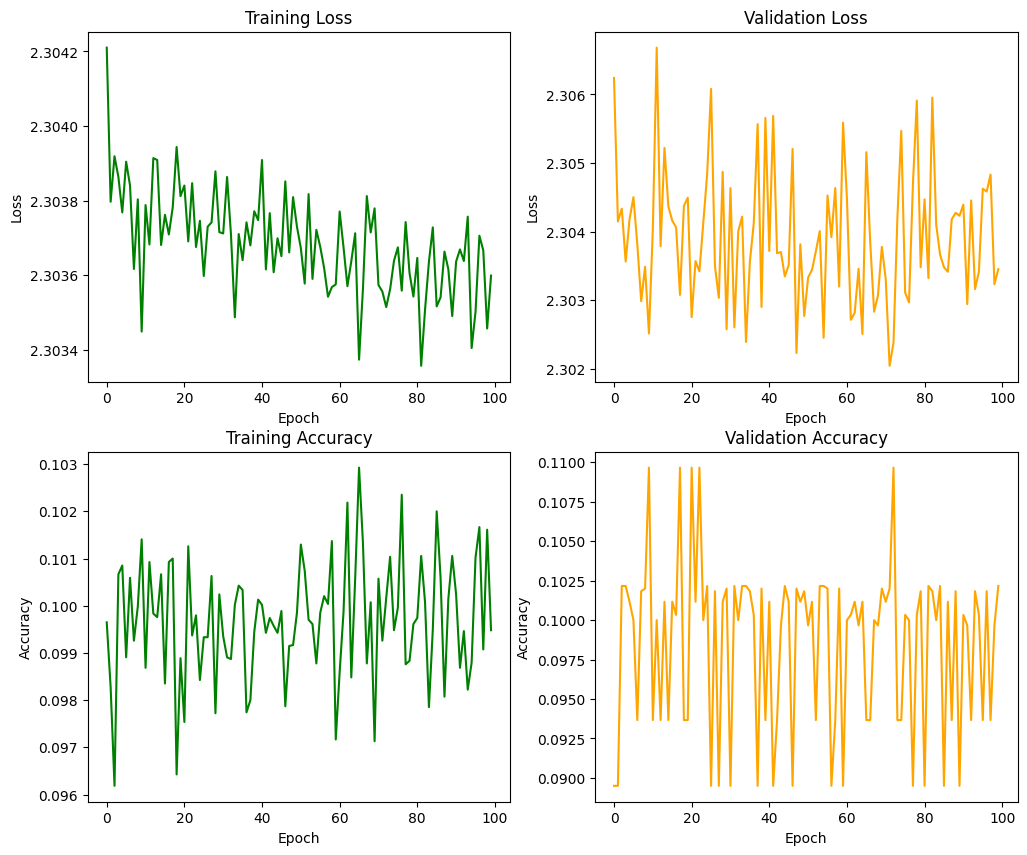

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")
ax[0, 1].plot(val_loss_lst, color="orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")
ax[1, 0].plot(train_acc_lst, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")
ax[1, 1].plot(val_acc_lst, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")
plt.show()

In [9]:
test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(
    test_target
)
print("Evaluation on test set:")
print(f"Accuracy: {test_acc}")

Evaluation on test set:
Accuracy: 0.1


# Advanced model training

## Train layers separately (fine-tuning)

In [26]:
def train_model(model, optimizer, criterion, epochs):
    train_loss_lst = []
    train_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []

    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        count = 0

        model.train()
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == y_train).sum().item()
            count += len(y_train)

        train_loss /= len(train_loader)
        train_loss_lst.append(train_loss)
        train_acc /= count
        train_acc_lst.append(train_acc)

        val_loss = 0.0
        val_acc = 0.0
        count = 0
        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
                count += len(y_val)

        val_loss /= len(val_loader)
        val_loss_lst.append(val_loss)
        val_acc /= count
        val_acc_lst.append(val_acc)
        print(
            f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}"
        )

    return train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst

In [21]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x

In [22]:
class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [23]:
first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)
lr = 1e-2
criterion = nn.CrossEntropyLoss()

In [27]:
# Giai đoạn 1 - Huấn luyện chỉ với thành phần đầu tiên: Ở bước đầu tiên, chỉ thành phần first tham gia vào quá trình huấn luyện.
# Thành phần này được nối với một lớp đầu ra để thực hiện dự đoán, trong khi các thành phần khác chưa được thêm vào.
model = nn.Sequential(first, nn.Linear(128, 10)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# training code here
epochs = 20
train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst = train_model(
    model, optimizer, criterion, epochs
)

EPOCH 1/20, Train_Loss: 1.2523, Train_Acc: 0.7319, Validation Loss: 0.8583, Val_Acc: 0.7982
EPOCH 2/20, Train_Loss: 0.7311, Train_Acc: 0.8154, Validation Loss: 0.6667, Val_Acc: 0.8150
EPOCH 3/20, Train_Loss: 0.6085, Train_Acc: 0.8244, Validation Loss: 0.5923, Val_Acc: 0.8173
EPOCH 4/20, Train_Loss: 0.5515, Train_Acc: 0.8302, Validation Loss: 0.5508, Val_Acc: 0.8268
EPOCH 5/20, Train_Loss: 0.5188, Train_Acc: 0.8340, Validation Loss: 0.5252, Val_Acc: 0.8293
EPOCH 6/20, Train_Loss: 0.4972, Train_Acc: 0.8381, Validation Loss: 0.5073, Val_Acc: 0.8312
EPOCH 7/20, Train_Loss: 0.4818, Train_Acc: 0.8407, Validation Loss: 0.4950, Val_Acc: 0.8338
EPOCH 8/20, Train_Loss: 0.4704, Train_Acc: 0.8427, Validation Loss: 0.4856, Val_Acc: 0.8357
EPOCH 9/20, Train_Loss: 0.4612, Train_Acc: 0.8443, Validation Loss: 0.4799, Val_Acc: 0.8352
EPOCH 10/20, Train_Loss: 0.4539, Train_Acc: 0.8461, Validation Loss: 0.4719, Val_Acc: 0.8393
EPOCH 11/20, Train_Loss: 0.4478, Train_Acc: 0.8470, Validation Loss: 0.4676, Va

In [28]:
# Giai đoạn 2 - Thêm thành phần thứ hai: Sau khi huấn luyện xong first, chúng ta thêm thành phần second vào mạng.
# Thành phần first được giữ cố định (không cập nhật trọng số), và chỉ second được tham gia vào quá trình huấn luyện.
for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(first, second, nn.Linear(128, 10)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# training code here
train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst = train_model(
    model, optimizer, criterion, epochs
)

EPOCH 1/20, Train_Loss: 2.2994, Train_Acc: 0.1201, Validation Loss: 2.2957, Val_Acc: 0.1735
EPOCH 2/20, Train_Loss: 2.2895, Train_Acc: 0.1554, Validation Loss: 2.2838, Val_Acc: 0.1877
EPOCH 3/20, Train_Loss: 2.2711, Train_Acc: 0.2134, Validation Loss: 2.2550, Val_Acc: 0.3603
EPOCH 4/20, Train_Loss: 2.2226, Train_Acc: 0.2936, Validation Loss: 2.1744, Val_Acc: 0.2828
EPOCH 5/20, Train_Loss: 2.0723, Train_Acc: 0.3379, Validation Loss: 1.9442, Val_Acc: 0.3578
EPOCH 6/20, Train_Loss: 1.8116, Train_Acc: 0.4499, Validation Loss: 1.7106, Val_Acc: 0.4525
EPOCH 7/20, Train_Loss: 1.6329, Train_Acc: 0.5439, Validation Loss: 1.5780, Val_Acc: 0.6417
EPOCH 8/20, Train_Loss: 1.5106, Train_Acc: 0.6048, Validation Loss: 1.4539, Val_Acc: 0.5972
EPOCH 9/20, Train_Loss: 1.3725, Train_Acc: 0.6412, Validation Loss: 1.3043, Val_Acc: 0.6572
EPOCH 10/20, Train_Loss: 1.2196, Train_Acc: 0.6849, Validation Loss: 1.1624, Val_Acc: 0.6908
EPOCH 11/20, Train_Loss: 1.0913, Train_Acc: 0.7191, Validation Loss: 1.0547, Va

In [29]:
# Giai đoạn 3 - Thêm thành phần thứ ba: Tiếp theo, thành phần third được thêm vào mạng.
# Tương tự, first và second vẫn giữ cố định, chỉ third tham gia huấn luyện.
for param in first.parameters():
    param.requires_grad = False

for param in second.parameters():
    param.requires_grad = False

model = nn.Sequential(first, second, third, nn.Linear(128, 10)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# training code here
train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst = train_model(
    model, optimizer, criterion, epochs
)

EPOCH 1/20, Train_Loss: 2.3021, Train_Acc: 0.1073, Validation Loss: 2.3004, Val_Acc: 0.0895
EPOCH 2/20, Train_Loss: 2.2951, Train_Acc: 0.1342, Validation Loss: 2.2906, Val_Acc: 0.1023
EPOCH 3/20, Train_Loss: 2.2835, Train_Acc: 0.1684, Validation Loss: 2.2753, Val_Acc: 0.1712
EPOCH 4/20, Train_Loss: 2.2575, Train_Acc: 0.2340, Validation Loss: 2.2342, Val_Acc: 0.3403
EPOCH 5/20, Train_Loss: 2.1838, Train_Acc: 0.2772, Validation Loss: 2.1140, Val_Acc: 0.2988
EPOCH 6/20, Train_Loss: 1.9921, Train_Acc: 0.3282, Validation Loss: 1.8633, Val_Acc: 0.3315
EPOCH 7/20, Train_Loss: 1.7541, Train_Acc: 0.4241, Validation Loss: 1.6682, Val_Acc: 0.4292
EPOCH 8/20, Train_Loss: 1.5952, Train_Acc: 0.5080, Validation Loss: 1.5377, Val_Acc: 0.5045
EPOCH 9/20, Train_Loss: 1.4641, Train_Acc: 0.5759, Validation Loss: 1.4043, Val_Acc: 0.6153
EPOCH 10/20, Train_Loss: 1.3244, Train_Acc: 0.6106, Validation Loss: 1.2652, Val_Acc: 0.5435
EPOCH 11/20, Train_Loss: 1.1937, Train_Acc: 0.6464, Validation Loss: 1.1513, Va

In [31]:
# Giai đoạn 4 - Mở khóa toàn bộ thành phần: Cuối cùng, sau khi thêm đủ các thành phần,
# chúng ta mở khóa tất cả các lớp trong mạng và thực hiện huấn luyện toàn bộ mô hình.
# Điều này đảm bảo rằng tất cả các lớp đều được tối ưu hóa chung để đạt hiệu suất tốt nhất.

for param in first.parameters():
    param.requires_grad = True

for param in second.parameters():
    param.requires_grad = True

for param in third.parameters():
    param.requires_grad = True

model = nn.Sequential(first, second, third, fourth, nn.Linear(128, 10)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# training code here
train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst = train_model(
    model, optimizer, criterion, epochs
)

EPOCH 1/20, Train_Loss: 2.1432, Train_Acc: 0.3433, Validation Loss: 1.9334, Val_Acc: 0.3658
EPOCH 2/20, Train_Loss: 1.6826, Train_Acc: 0.4841, Validation Loss: 1.4802, Val_Acc: 0.5042
EPOCH 3/20, Train_Loss: 1.3317, Train_Acc: 0.5600, Validation Loss: 1.2342, Val_Acc: 0.5750
EPOCH 4/20, Train_Loss: 1.1514, Train_Acc: 0.5964, Validation Loss: 1.1089, Val_Acc: 0.6008
EPOCH 5/20, Train_Loss: 1.0501, Train_Acc: 0.6229, Validation Loss: 1.0286, Val_Acc: 0.5980
EPOCH 6/20, Train_Loss: 0.9800, Train_Acc: 0.6490, Validation Loss: 0.9691, Val_Acc: 0.6480
EPOCH 7/20, Train_Loss: 0.9238, Train_Acc: 0.6793, Validation Loss: 0.9168, Val_Acc: 0.6943
EPOCH 8/20, Train_Loss: 0.8735, Train_Acc: 0.7127, Validation Loss: 0.8700, Val_Acc: 0.7005
EPOCH 9/20, Train_Loss: 0.8273, Train_Acc: 0.7389, Validation Loss: 0.8259, Val_Acc: 0.7315
EPOCH 10/20, Train_Loss: 0.7877, Train_Acc: 0.7552, Validation Loss: 0.7867, Val_Acc: 0.7575
EPOCH 11/20, Train_Loss: 0.7554, Train_Acc: 0.7666, Validation Loss: 0.7562, Va

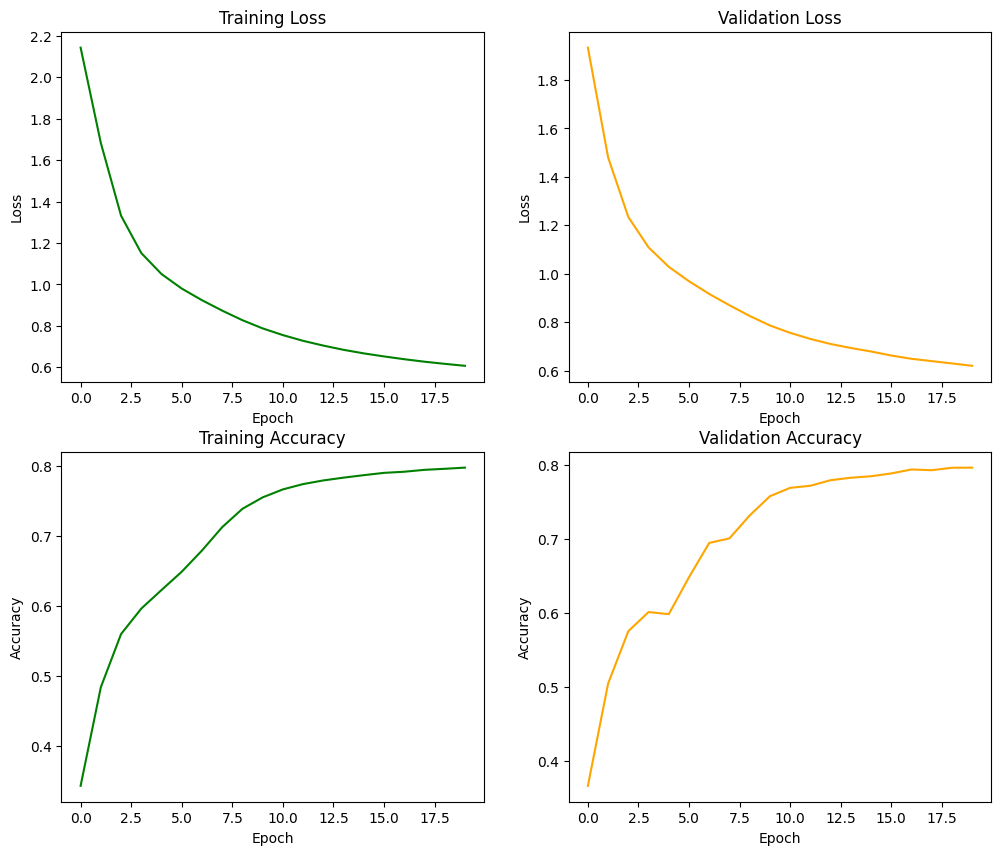

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")
ax[0, 1].plot(val_loss_lst, color="orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")
ax[1, 0].plot(train_acc_lst, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")
ax[1, 1].plot(val_acc_lst, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")
plt.show()

In [33]:
test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(
    test_target
)
print("Evaluation on test set:")
print(f"Accuracy: {test_acc}")

Evaluation on test set:
Accuracy: 0.7877
